# IMT 573 - Problem Set 4 - Working With Data Part 2

### Instructions

Before beginning this assignment, please ensure you have access to a working instance of Jupyter Notebooks with Python 3.

1. First, replace the “YOUR NAME HERE” text in the next cell with your own full name. Any collaborators must also be listed in this cell.

2. Be sure to include well-documented (e.g. commented) code cells, figures, and clearly written text  explanations as necessary. Any figures should be clearly labeled and appropriately referenced within the text. Be sure that each visualization adds value to your written explanation; avoid redundancy – you do no need four different visualizations of the same pattern.

3. Collaboration on problem sets and labs is fun, useful, and encouraged. However, each student must turn in an individual write-up in their own words as well as code/work that is their own. Regardless of whether you work with others, what you turn in must be your own work; this includes code and interpretation of results. The names of all collaborators must be listed on each assignment. Do not copy-and-paste from other students’ responses or code - your code should never be on any other student's screen or machine.

4. All materials and resources that you use (with the exception of lecture slides) must be appropriately referenced within your assignment.

5. Partial credit will be awarded for each question for which a serious attempt at finding an answer has been shown. Students are *strongly* encouraged to attempt each question and document their reasoning process even if they cannot find the correct answer. 

6. After completing the assignment, ensure that your code can run from start to finish without issue. Restart the kernal and run all cells to double check.

Name: Steve Gonzales Collaborators: none

For this assignment, you'll need (at least) the following packages. If the package does not load, be sure it is properly installed.

In [1]:
import pandas as pd
import censusgeocode as cg
import seaborn as sns
import matplotlib.pyplot as plt

In this problem set, we will be joining disparate sets of data - namely: Seattle police crime data, information on Seattle police beats, and education attainment from the US Census. Our goal is to build a dataset where we can examine questions around crimes in Seattle and the educational attainment of people living in the areas in which the crime occurred; this requires data
to be combined from these multiple individual sources.

As a general rule, be sure to keep copies of the original dataset(s) as you work through cleaning (remember
data provenance!).

### Problem 1: Crime Data

Load the Seattle crime data from the provided `crime_data.csv` data file. The data is a modified version of the data available [here](https://data.seattle.gov/Public-Safety/Crime-Data/4fs7-3vj5). We will call this dataset the “Crime Dataset” going forward.

In [2]:
df_crime = pd.read_csv('Crime_Data.csv')
print(df_crime.columns.tolist())
display(df_crime.head(3))

['Report Number', 'Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time', 'Crime Subcategory', 'Primary Offense Description', 'Precinct', 'Sector', 'Beat', 'Neighborhood']


,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,1975000079415,12/16/1975,900.0,12/16/1975,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK
1,1976000069169,01/01/1976,1.0,01/31/1976,2359.0,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,UNKNOWN,NaN,NaN,UNKNOWN
2,1979000049118,01/28/1979,1600.0,02/09/1979,1430.0,CAR PROWL,THEFT-CARPROWL,EAST,G,G2,CENTRAL AREA/SQUIRE PARK


#### (a) Basic inspection

Perform a basic inspection of the Crime Dataset and discuss what you find. How many observations are there? Is there any anomolous or missing data?

In [3]:
display(df_crime.dtypes)
display(df_crime.describe())

Report Number                    int64
Occurred Date                   object
Occurred Time                  float64
Reported Date                   object
Reported Time                  float64
Crime Subcategory               object
Primary Offense Description     object
Precinct                        object
Sector                          object
Beat                            object
Neighborhood                    object
dtype: object

,Report Number,Occurred Time,Reported Time
count,5.235910e+05,523589.000000,523589.000000
mean,1.634634e+13,1358.647834,1353.365256
std,7.421091e+12,688.350593,589.365021
min,2.008000e+08,0.000000,0.000000
25%,2.008000e+13,900.000000,950.000000
50%,2.012000e+13,1500.000000,1407.000000
75%,2.016000e+13,1920.000000,1817.000000
max,2.019000e+13,2359.000000,2359.000000


In [4]:
# Nothing unusual is indicated, but the dates and times are not in Python formats, so we can add that
# df_crime['occured_dt']
import datetime

# Create a function so that we can apply Datetime via vector operations
def convert_to_datetime(row, date_col, time_col):
    date_str = row[date_col]
    time_str = str(row[time_col])
    if pd.isna(date_str) or pd.isna(time_str):  # Handle missing values
        return pd.NaT  # Return NaT (Not a Time) for missing values
    if '.' in time_str:
        time_str = time_str.split('.')[0] # Keep only the number to the left of the decimal
    # e.g. Guessing that 1400.00=14:00
    if len(time_str) < 4:
        time_str = time_str.zfill(4)
    try:
        # There is a high liklihood of bad data in conversions like this so we use a Try
        date_time_str = f"{date_str} {time_str}"
        return datetime.datetime.strptime(date_time_str, '%m/%d/%Y %H%M')
    except ValueError:
        try:
            return datetime.datetime.strptime(date_time_str, '%m/%d/%Y %H:%M')
        except ValueError:
            print(f"Error converting date/time: {date_time_str}")
            return pd.NaT  # Return NaT for parsing errors
# Our data set is large, so test on a small subset for accuracy
df_test = df_crime.head(100).copy()
df_test['occurred_dt'] = df_test.apply(convert_to_datetime, args=('Occurred Date', 'Occurred Time'), axis=1)
df_test['reported_dt'] = df_test.apply(convert_to_datetime, args=('Reported Date', 'Reported Time'), axis=1)
display(df_test.drop(columns=['Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time']))

Error converting date/time: 01/01/1999 0nan


,Report Number,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,occurred_dt,reported_dt
0,1975000079415,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK,1975-12-16 09:00:00,1975-12-16 15:00:00
1,1976000069169,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,UNKNOWN,NaN,NaN,UNKNOWN,1976-01-01 00:01:00,1976-01-31 23:59:00
2,1979000049118,CAR PROWL,THEFT-CARPROWL,EAST,G,G2,CENTRAL AREA/SQUIRE PARK,1979-01-28 16:00:00,1979-02-09 14:30:00
3,19810000305573,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,BRIGHTON/DUNLAP,1981-08-22 20:29:00,1981-08-22 20:30:00
4,1981000076456,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,ROXHILL/WESTWOOD/ARBOR HEIGHTS,1981-02-14 20:00:00,1981-02-15 04:35:00
...,...,...,...,...,...,...,...,...,...
95,20070000321951,RAPE,RAPE-STRONGARM,WEST,M,M1,DOWNTOWN COMMERCIAL,2007-08-06 01:00:00,2007-08-06 01:00:00
96,20070000324135,RAPE,SEXOFF-OTHER OBJECT,EAST,G,G3,JUDKINS PARK/NORTH BEACON HILL,2007-07-30 00:00:00,2007-07-30 00:00:00
97,20070000327115,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,EAST,E,E3,FIRST HILL,2007-08-09 12:46:00,2007-08-09 12:46:00
98,20070000329837,RAPE,RAPE-STRONGARM,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS,2007-08-11 03:00:00,2007-08-11 05:59:00


In [5]:
# Crime columns ['Report Number', 'Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time', 'Crime Subcategory', 'Primary Offense Description', 'Precinct', 'Sector', 'Beat', 'Neighborhood']
print(f"Total unique observations: {len(df_crime['Report Number'].unique()):,}")

Total unique observations: 523,591


In [6]:
# Sector and Beat have NaN values; how many?
print(f"Total NaN Sectors {df_crime['Sector'].isna().sum():,}")
print(f"Total NaN Beats {df_crime['Beat'].isna().sum():,}")
bad_sector_beat = df_crime[df_crime[['Sector', 'Beat']].isna().any(axis=1)]
display(bad_sector_beat)

Total NaN Sectors 3,346
Total NaN Beats 3,298


,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
1,1976000069169,01/01/1976,1.0,01/31/1976,2359.0,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,UNKNOWN,NaN,NaN,UNKNOWN
9,19990000333737,NaN,NaN,01/01/1999,NaN,THEFT-SHOPLIFT,THEFT-SHOPLIFT,UNKNOWN,NaN,NaN,UNKNOWN
19,20040000379590,01/01/1998,0.0,09/09/2004,1650.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
60,20070000149043,03/08/2007,1824.0,04/14/2007,0.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
86,20070000299827,07/21/2007,430.0,07/22/2007,2145.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...
522730,20190000904938,05/01/2019,1200.0,05/03/2019,845.0,THEFT-ALL OTHER,THEFT-OTH,UNKNOWN,NaN,NaN,UNKNOWN
522733,20190000904942,05/03/2019,1310.0,05/03/2019,2316.0,THEFT-ALL OTHER,THEFT-OTH,UNKNOWN,NaN,NaN,UNKNOWN
522917,2019000091643,03/14/2019,1539.0,03/14/2019,1539.0,TRESPASS,TRESPASS,UNKNOWN,NaN,NaN,UNKNOWN
523223,2019000095610,03/16/2019,2300.0,03/17/2019,1407.0,THEFT-ALL OTHER,THEFT-PKPOCKET,UNKNOWN,NaN,NaN,UNKNOWN


In [7]:
print(f"""{len(bad_sector_beat):,} rows with NaN data about where the crime took place. 
These rows are not going to be useful for most analysis that involves a location.""")

3,354 rows with NaN data about where the crime took place. 
These rows are not going to be useful for most analysis that involves a location.


In [8]:
# Look at Date of incident/report
print(len(df_crime))
print(f"Total NaN Incident Dates {df_crime['Occurred Date'].isna().sum():,}")
print(f"Total NaN Reported Dates {df_crime['Reported Date'].isna().sum():,}")
# Show the bad data
bad_indicent_date = df_crime[df_crime[['Occurred Date', 'Reported Date']].isna().any(axis=1)]
display(bad_indicent_date)

523591
Total NaN Incident Dates 2
Total NaN Reported Dates 0


,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
9,19990000333737,NaN,NaN,01/01/1999,NaN,THEFT-SHOPLIFT,THEFT-SHOPLIFT,UNKNOWN,NaN,NaN,UNKNOWN
122,20070000430946,NaN,NaN,01/01/2007,NaN,RAPE,RAPE-OTHER,UNKNOWN,NaN,NaN,UNKNOWN


Only two rows out of 500K+ so we'll just ignore these as they are not material.

#### (b) Years of crimes

Examine the years in which crimes were committed in the dataset. What is the earliest year in the dataset? Are there any distinct trends with the annual number of crimes committed in the dataset?

In [9]:
# Clean the date and time fields and copy them into two new fields
# Add year columns for reported and occured
df_crime_new = df_crime.copy()
df_crime_new['occurred_dt'] = df_test.apply(convert_to_datetime, args=('Occurred Date', 'Occurred Time'), axis=1)
df_crime_new['reported_dt'] = df_test.apply(convert_to_datetime, args=('Reported Date', 'Reported Time'), axis=1)
df_crime_new = df_crime_new.drop(columns=['Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time'])
df_crime_new['occurred_yr'] = df_crime_new['occurred_dt'].dt.year
df_crime_new['reported_yr'] = df_crime_new['reported_dt'].dt.year
display(df_crime_new)

Error converting date/time: 01/01/1999 0nan


,Report Number,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,occurred_dt,reported_dt,occurred_yr,reported_yr
0,1975000079415,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK,1975-12-16 09:00:00,1975-12-16 15:00:00,1975.0,1975.0
1,1976000069169,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,UNKNOWN,NaN,NaN,UNKNOWN,1976-01-01 00:01:00,1976-01-31 23:59:00,1976.0,1976.0
2,1979000049118,CAR PROWL,THEFT-CARPROWL,EAST,G,G2,CENTRAL AREA/SQUIRE PARK,1979-01-28 16:00:00,1979-02-09 14:30:00,1979.0,1979.0
3,19810000305573,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,BRIGHTON/DUNLAP,1981-08-22 20:29:00,1981-08-22 20:30:00,1981.0,1981.0
4,1981000076456,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,ROXHILL/WESTWOOD/ARBOR HEIGHTS,1981-02-14 20:00:00,1981-02-15 04:35:00,1981.0,1981.0
...,...,...,...,...,...,...,...,...,...,...,...
523586,2019000099944,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,SOUTH,O,O3,MID BEACON HILL,NaT,NaT,NaN,NaN
523587,2019000099946,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,C,C2,MONTLAKE/PORTAGE BAY,NaT,NaT,NaN,NaN
523588,2019000099949,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,SOUTH,S,S2,RAINIER BEACH,NaT,NaT,NaN,NaN
523589,2019000099974,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,L,L2,NORTHGATE,NaT,NaT,NaN,NaN


In [10]:
nat_count_occurred_dt = df_crime_new['occurred_dt'].isna().sum()
nat_count_reported_dt = df_crime_new['reported_dt'].isna().sum()

print(f"Number of NaT values in column 'occurred_dt': {nat_count_occurred_dt}")
print(f"Number of NaT values in column 'reported_dt': {nat_count_reported_dt}")

Number of NaT values in column 'occurred_dt': 523492
Number of NaT values in column 'reported_dt': 523492


In [11]:
# That didn't work to convert those dates. Need to update our function
# Create a function so that we can apply Datetime via vector operations
def convert_to_datetime_v2(row, date_col, time_col):
    date_str = row[date_col]
    time_str = str(row[time_col])
    if pd.isna(date_str): # need to just ignore if no time
        return pd.NaT  # Return NaT (Not a Time) for missing values
    if pd.isna(time_str) or 'nan' in time_str:
        time_str = '00:00'
    if '.' in time_str:
        time_str = time_str.split('.')[0] # Keep only the number to the left of the decimal
    # e.g. Guessing that 1400.00=14:00
    if len(time_str) < 4:
        time_str = time_str.zfill(4)
    try:
        # There is a high liklihood of bad data in conversions like this so we use a Try
        date_time_str = f"{date_str} {time_str}"
        return datetime.datetime.strptime(date_time_str, '%m/%d/%Y %H%M')
    except ValueError:
        try:
            return datetime.datetime.strptime(date_time_str, '%m/%d/%Y %H:%M')
        except ValueError:
            print(f"Error converting date/time: {date_time_str}")
            return pd.NaT  # Return NaT for parsing errors
# Our data set is large, so test on a small subset for accuracy
df_test = df_crime.tail(100).copy()
df_test['occurred_dt'] = df_test.apply(convert_to_datetime, args=('Occurred Date', 'Occurred Time'), axis=1)
df_test['reported_dt'] = df_test.apply(convert_to_datetime, args=('Reported Date', 'Reported Time'), axis=1)
display(df_test.drop(columns=['Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time']))

,Report Number,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,occurred_dt,reported_dt
523491,2019000098657,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,WEST,Q,Q1,MAGNOLIA,2019-03-19 18:29:00,2019-03-19 19:05:00
523492,2019000098670,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,U,U3,ROOSEVELT/RAVENNA,2019-03-19 19:19:00,2019-03-19 21:55:00
523493,2019000098705,THEFT-BUILDING,THEFT-BUILDING,SOUTH,O,O1,SODO,2019-03-19 19:35:00,2019-03-19 19:49:00
523494,2019000098719,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,U,U3,ROOSEVELT/RAVENNA,2019-03-19 20:04:00,2019-03-19 21:26:00
523495,2019000098722,MOTOR VEHICLE THEFT,VEH-THEFT-AUTO,NORTH,B,B2,FREMONT,2019-03-19 09:30:00,2019-03-19 19:59:00
...,...,...,...,...,...,...,...,...,...
523586,2019000099944,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,SOUTH,O,O3,MID BEACON HILL,2019-03-20 17:13:00,2019-03-20 17:13:00
523587,2019000099946,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,C,C2,MONTLAKE/PORTAGE BAY,2019-03-20 07:30:00,2019-03-20 17:21:00
523588,2019000099949,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,SOUTH,S,S2,RAINIER BEACH,2019-03-20 17:24:00,2019-03-20 17:24:00
523589,2019000099974,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,L,L2,NORTHGATE,2019-03-20 17:50:00,2019-03-20 19:04:00


In [12]:
# Start over with a new copy
df_crime_new = df_crime.copy()
df_crime_new['occurred_dt'] = df_crime_new.apply(convert_to_datetime_v2, args=('Occurred Date', 'Occurred Time'), axis=1)
df_crime_new['reported_dt'] = df_crime_new.apply(convert_to_datetime_v2, args=('Reported Date', 'Reported Time'), axis=1)
df_crime_new = df_crime_new.drop(columns=['Occurred Date', 'Occurred Time', 'Reported Date', 'Reported Time'])
df_crime_new['occurred_yr'] = df_crime_new['occurred_dt'].dt.year
df_crime_new['reported_yr'] = df_crime_new['reported_dt'].dt.year
# Group by year for both occurred and reported
df_crimes_occurred = df_crime_new['occurred_yr'].value_counts().sort_index().fillna(0)
df_crimes_reported = df_crime_new['reported_yr'].value_counts().sort_index().fillna(0)
# Combine the two DFs
df_crimes_combined = pd.concat([df_crimes_occurred, df_crimes_reported], axis=1, keys=['occurred_yr', 'reported_yr'])
# Convert NaN to 0
df_crimes_combined = df_crimes_combined.fillna(0)
# Convert cols to Integer
df_crimes_combined = df_crimes_combined.astype(int)
# Convert the index to integers
df_crimes_combined.index = df_crimes_combined.index.astype(int)
display(df_crimes_combined)

,occurred_yr,reported_yr
1908,1,0
1964,1,0
1973,1,0
1974,1,0
1975,2,1
1976,2,1
1977,1,0
1978,1,0
1979,2,1
1980,2,0


In [13]:
nat_count_occurred_dt = df_crime_new['occurred_dt'].isna().sum()
nat_count_reported_dt = df_crime_new['reported_dt'].isna().sum()

print(f"Number of NaT values in column 'occurred_dt': {nat_count_occurred_dt}")
print(f"Number of NaT values in column 'reported_dt': {nat_count_reported_dt}")

Number of NaT values in column 'occurred_dt': 2
Number of NaT values in column 'reported_dt': 0


In [14]:
# now the data looks better
print(f"The first year of data in the data set is: {df_crime_new['occurred_dt'].min().strftime('%Y')}")
print("However, this is highly unlikely, it's probably transposed data 1908 = 1980")
print("2019 looks to have partial data as there is no public evidence of significant drop in crime")
print("There are differences between the two dates, most likely due to data quality issues and incidents that occurred in December but were reported in January.")

The first year of data in the data set is: 1908
However, this is highly unlikely, it's probably transposed data 1908 = 1980
2019 looks to have partial data as there is no public evidence of significant drop in crime
There are differences between the two dates, most likely due to data quality issues and incidents that occurred in December but were reported in January.


I believe there is something wrong with this data set. Looking at the Seattle PD website, we clearly see a downward trend over the past 30 years, however, our data shows a huge spike in 2008:
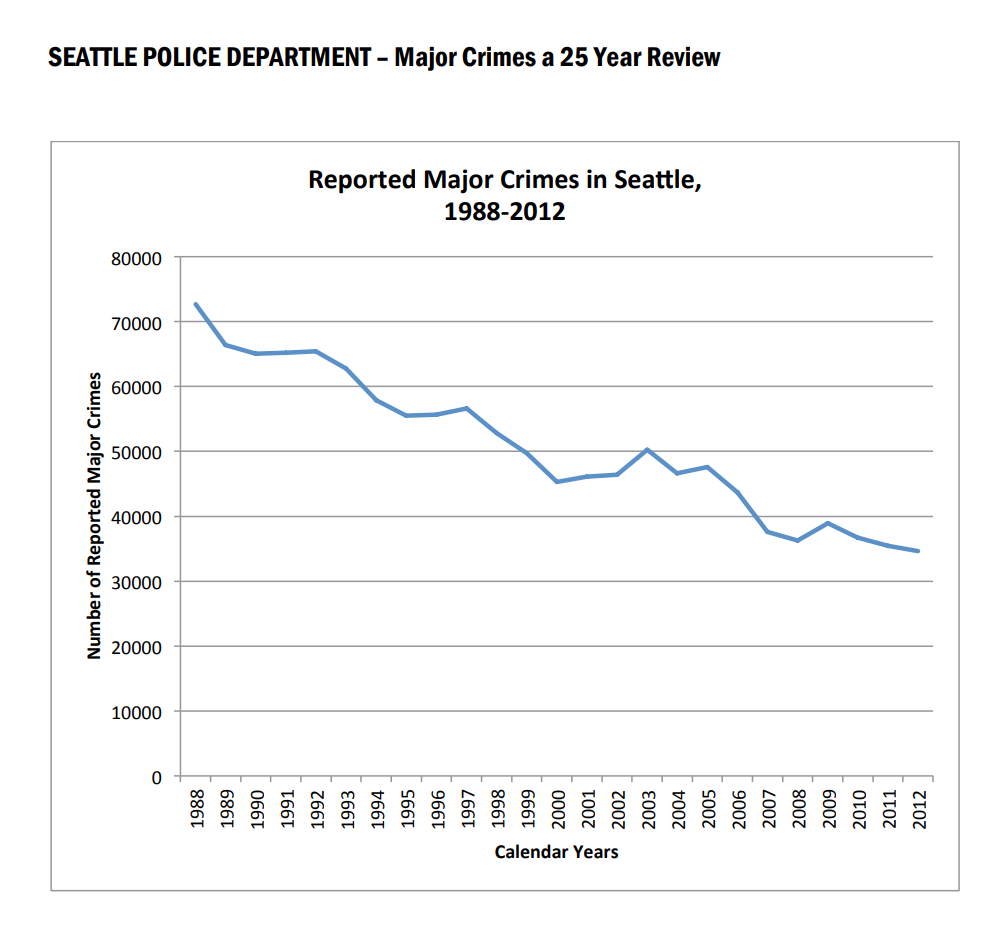
Source: https://www.seattle.gov/documents/Departments/Police/crime/Crime_1988_2012.pdf<p>
The more likely situation is that data was converted from paper to digital in 2008 and for the data set we have it is not accurate prior to 2008.

#### (c) Filter data on years

Subset the data to only include crimes that were committed after 2011 (remember good practices of data
provenance!). Going forward, we will use this data subset. Print the shape of your dataset after doing this.

In [15]:
# Filtering out data before 2012, keeping the date column
df_crime_filtered = df_crime_new[(df_crime_new['occurred_yr'] > 2011)]
display(df_crime_filtered)
print(f'Shape: {df_crime_filtered.shape}')
print(f"Min occured date: {df_crime_filtered['occurred_dt'].min()} Max occured date: {df_crime_filtered['occurred_dt'].max()} ")

,Report Number,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,occurred_dt,reported_dt,occurred_yr,reported_yr
172763,20120000100012,NARCOTIC,NARC-POSSESS-MARIJU,WEST,K,K2,PIONEER SQUARE,2012-04-02 20:40:00,2012-04-03 00:28:00,2012.0,2012
172764,20120000100035,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-GUN,NORTH,B,B2,BALLARD SOUTH,2012-04-02 21:00:00,2012-04-02 21:03:00,2012.0,2012
172765,20120000100055,MOTOR VEHICLE THEFT,VEH-THEFT-AUTO,NORTH,J,J1,BALLARD NORTH,2012-04-02 19:30:00,2012-04-02 21:26:00,2012.0,2012
172766,20120000100062,DUI,DUI-LIQUOR,EAST,E,E3,CAPITOL HILL,2012-04-02 21:44:00,2012-04-02 21:44:00,2012.0,2012
172767,20120000100092,ROBBERY-RESIDENTIAL,ROBBERY-RESIDENCE-BODYFORCE,EAST,C,C2,MADISON PARK,2012-04-02 22:18:00,2012-04-02 22:18:00,2012.0,2012
...,...,...,...,...,...,...,...,...,...,...,...
523586,2019000099944,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,SOUTH,O,O3,MID BEACON HILL,2019-03-20 17:13:00,2019-03-20 17:13:00,2019.0,2019
523587,2019000099946,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,C,C2,MONTLAKE/PORTAGE BAY,2019-03-20 07:30:00,2019-03-20 17:21:00,2019.0,2019
523588,2019000099949,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,SOUTH,S,S2,RAINIER BEACH,2019-03-20 17:24:00,2019-03-20 17:24:00,2019.0,2019
523589,2019000099974,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,L,L2,NORTHGATE,2019-03-20 17:50:00,2019-03-20 19:04:00,2019.0,2019


Shape: (350053, 11)
Min occured date: 2012-01-01 00:00:00 Max occured date: 2019-05-07 09:50:00 


#### (d) Looking at frequency of beats 

Each of the records has a police beat associated with it. You can learn more about police beats [here](https://www.seattle.gov/police/information-and-data/data/tweets-by-beat). How frequently are the beats in the (filtered) Crime Dataset listed? Are there any anomolies with how frequently some of the beats are listed? Are there missing beats?

In [16]:
na_count_beats = df_crime_filtered['Beat'].isna().sum()
print(f"Number of NAs in column 'Beat': {na_count_beats:,} or {na_count_beats/len(df_crime_filtered):%}")

Number of NAs in column 'Beat': 2,054 or 0.586768%


In [17]:
print("There are missing Beats, but less than 1%")
beat_counts = df_crime_filtered.groupby('Beat').size()
print(beat_counts)

There are missing Beats, but less than 1%
Beat
B1      7954
B2      9253
B3      8846
C1      5694
C2      4789
C3      4726
CTY        1
D1      8066
D2      7491
D3      6530
DET        7
E1      7459
E2     10200
E3      7032
F1      4332
F2      6429
F3      5361
G1      3257
G2      5259
G3      4327
J1      5668
J2      6585
J3      7203
K          1
K1      6611
K2      6560
K3     11611
L1      5823
L2     10049
L3      5710
M1      9883
M2     10210
M3      9723
N          1
N1      5303
N2      7409
N3      7517
O1      4523
O2      2894
O3      3239
Q1      5647
Q2      8159
Q3      9249
R1      6080
R2      7448
R3      6909
S          4
S1      4819
S2      5139
S3      6027
SS         1
U1     10157
U2      8866
U3      9019
W          3
W1      5135
W2      6514
W3      5286
WS         1
dtype: int64


In [18]:
# Group by 'Beat' and count the number of occurrences
beat_counts = df_crime_filtered[(df_crime_filtered['Beat'].str.len() == 2)].groupby('Beat').size()
# Calculate mean, median, and mode
mean_count = beat_counts.mean()
median_count = beat_counts.median()

# Print the results
print("Beat Counts:\n", beat_counts)
print(f"\nMean count: {mean_count}")
print(f"Median count: {median_count}")

Beat Counts:
 Beat
B1     7954
B2     9253
B3     8846
C1     5694
C2     4789
C3     4726
D1     8066
D2     7491
D3     6530
E1     7459
E2    10200
E3     7032
F1     4332
F2     6429
F3     5361
G1     3257
G2     5259
G3     4327
J1     5668
J2     6585
J3     7203
K1     6611
K2     6560
K3    11611
L1     5823
L2    10049
L3     5710
M1     9883
M2    10210
M3     9723
N1     5303
N2     7409
N3     7517
O1     4523
O2     2894
O3     3239
Q1     5647
Q2     8159
Q3     9249
R1     6080
R2     7448
R3     6909
S1     4819
S2     5139
S3     6027
SS        1
U1    10157
U2     8866
U3     9019
W1     5135
W2     6514
W3     5286
WS        1
dtype: int64

Mean count: 6565.698113207547
Median count: 6530.0


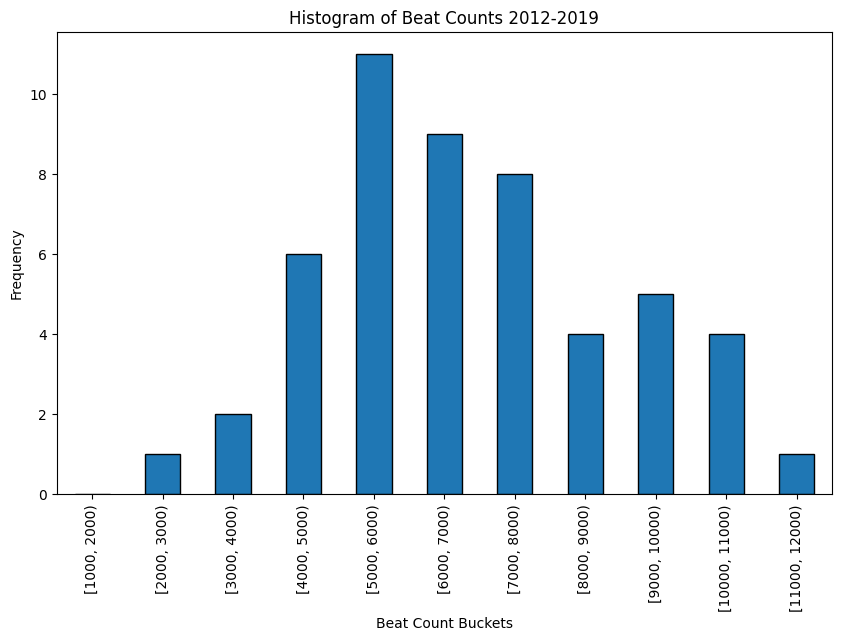

In [19]:
# Build a Histogram to see if there are any obvious issues
bins = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]
# Use pd.cut to bucket the values
bucketed_counts = pd.cut(beat_counts, bins=bins, right=False)
# Count the number of occurrences in each bucket
bucketed_counts.value_counts().sort_index().plot(kind='bar', edgecolor='black', figsize=(10, 6))
# Adding titles and labels
plt.title(f"Histogram of Beat Counts {int(df_crime_filtered['occurred_yr'].min())}-{int(df_crime_filtered['occurred_yr'].max())}")
plt.xlabel('Beat Count Buckets')
plt.ylabel('Frequency')
# Display the plot
plt.show()

The Beats do seem to be mostly evenly distributed but slightly Left-skewed. It is highly likely that Seattle PD attempts to evenly size the Beats for easier human resource planning.<p>
A few of the Beats have only 1 reported crime, which lead me to believe that this is bad data. E.g. K has 1, that is likely 'K3' but was mistyped.<p>
The largest reported crime is in K3 with corresponds to the Rainer Beach area of Seattle and cross checks are probably good data:
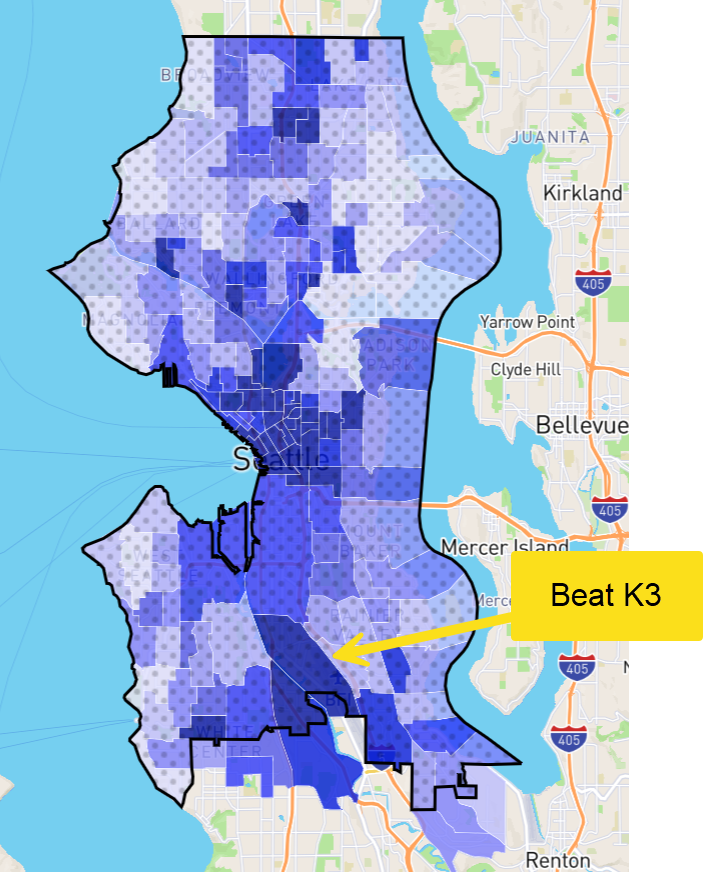
Source: https://www.neighborhoodscout.com/wa/seattle/crime

### Problem 2: Police Beat Data

Load the data on Seattle police beats provided in the police_beat_and_precinct_centerpoints.csv. This is the same data that you used in Lab 4. You can learn more about police precincts and beats [here](https://www.seattle.gov/police/about-us/about-policing/precinct-and-patrol-boundaries). The data can be found in the `Police_Beat_and_Precinct_Centerpoints.csv` file.

In [20]:
import os
# I didn't know if this assignment used the exact same dataset as the previous
# this should work when the grader runs it either way
if os.path.exists('Police_Beat_and_Precinct_Centerpoints-1.csv'):
    df_beat = pd.read_csv('Police_Beat_and_Precinct_Centerpoints-1.csv')
else:
    df_beat = pd.read_csv('Police_Beat_and_Precinct_Centerpoints.csv')
display(df_beat.head(10))
print(df_beat.shape)

,Name,Location 1,Latitude,Longitude
0,B1,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099
1,B2,"(47.6790521901374, -122.391748391741)",47.67905,-122.39175
2,B3,"(47.6812920482227, -122.364236159741)",47.68129,-122.36424
3,C1,"(47.6342500180223, -122.315684762418)",47.63425,-122.31568
4,C2,"(47.6192385752996, -122.313557430551)",47.61924,-122.31356
5,C3,"(47.6300792887474, -122.292087128251)",47.63008,-122.29209
6,CITYWIDE,"(47.6210041048652, -122.332993498998)",47.62100,-122.33299
7,D1,"(47.6274421308028, -122.345705781837)",47.62744,-122.34571
8,D2,"(47.6256548876049, -122.331370005506)",47.62565,-122.33137
9,D3,"(47.6103493249325, -122.328653706199)",47.61035,-122.32865


(57, 4)


#### (a) Missing beats

Does the (filtered) Crime Dataset include police beats that are not present in the Beats Dataset? If so, how many and
with what frequency do they occur? Would you say that these comprise a large number of the observations
in the Crime Dataset or are they rather infrequent? Do you think removing them would drastically alter the
scope of the Crime Dataset?

In [21]:
# Filtering out data before 2012, keeping the date column
print(f'Shape: {df_crime_filtered.shape}')
print(f"Min occured date: {df_crime_filtered['occurred_dt'].min()} Max occured date: {df_crime_filtered['occurred_dt'].max()} ")
# Find 'Name' entries in df_beats that are not in df_crime_filtered['Beat']
beats_not_in_crime = df_beat[~df_beat['Name'].isin(df_crime_filtered['Beat'])]['Name']

# Find 'Beat' entries in df_crime_filtered that are not in df_beats['Name']
crime_not_in_beats = df_crime_filtered[~df_crime_filtered['Beat'].isin(df_beat['Name'])]['Beat'].dropna()

# Print the results
print(f"Names in df_beats not in df_crime_filtered['Beat']:\n{beats_not_in_crime.tolist()}")
print(f"Beats in df_crime_filtered not in df_beats['Name']:\n{crime_not_in_beats.tolist()}")

Shape: (350053, 11)
Min occured date: 2012-01-01 00:00:00 Max occured date: 2019-05-07 09:50:00 
Names in df_beats not in df_crime_filtered['Beat']:
['CITYWIDE', 'E', 'SE', 'SW']
Beats in df_crime_filtered not in df_beats['Name']:
['S', 'SS', 'S', 'DET', 'DET', 'CTY', 'S', 'DET', 'S', 'DET', 'WS', 'DET', 'K', 'DET', 'DET']


In [22]:
# Find 'Name' entries in df_beats that are not in df_crime_filtered['Beat']
beats_not_in_crime = df_beat[~df_beat['Name'].isin(df_crime_filtered['Beat'])]['Name']

# Find 'Beat' entries in df_crime_filtered that are not in df_beats['Name']
crime_not_in_beats = df_crime_filtered[~df_crime_filtered['Beat'].isin(df_beat['Name'])]['Beat'].dropna()

# Create DataFrames for missing data
df_missing_beats = pd.DataFrame({'Type': 'Missing_Beats', 'Name': beats_not_in_crime})
df_missing_crimes = pd.DataFrame({'Type': 'Missing_Names', 'Beat': crime_not_in_beats})

# Count occurrences and group by 'Beat' or 'Name'
missing_beat_counts = df_missing_beats.groupby(['Type', 'Name']).size().reset_index(name='Count')
missing_crime_counts = df_missing_crimes.groupby(['Type', 'Beat']).size().reset_index(name='Count')

# Print the results
print(f"Missing Beats (Name) from Police_Beat_and_Precinct_Centerpoints not in Crime_Data, grouped by Name:\n{missing_beat_counts}")
print(" ")
print(f"Missing Beats from Crime_Data not in Police_Beat_and_Precinct_Centerpoints counts grouped by Beat:\n{missing_crime_counts}")

Missing Beats (Name) from Police_Beat_and_Precinct_Centerpoints not in Crime_Data, grouped by Name:
            Type      Name  Count
0  Missing_Beats  CITYWIDE      1
1  Missing_Beats         E      1
2  Missing_Beats        SE      1
3  Missing_Beats        SW      1
 
Missing Beats from Crime_Data not in Police_Beat_and_Precinct_Centerpoints counts grouped by Beat:
            Type Beat  Count
0  Missing_Names  CTY      1
1  Missing_Names  DET      7
2  Missing_Names    K      1
3  Missing_Names    S      4
4  Missing_Names   SS      1
5  Missing_Names   WS      1


This data is very small: less than .1% so it should not skew the data at all.

#### (b) Filtering beats

Let’s remove all instances in the (filtered) Crime Dataset that have beats which occur fewer than 10 times the dataset. Also remove any observations with missing beats. After only keeping years of interest and filtering based on frequency of the beat, how many observations do we now have in the Crime Dataset?

In [23]:
# Remove observations with missing beats
df_crime_filtered = df_crime_filtered.dropna(subset=['Beat'])

# Count occurrences of each beat
beat_counts = df_crime_filtered['Beat'].value_counts()

# Filter out beats that occur fewer than 10 times
beats_to_keep = beat_counts[beat_counts >= 10].index
df_crime_filtered = df_crime_filtered[df_crime_filtered['Beat'].isin(beats_to_keep)]

print(f"Number of observations in the filtered Crime Dataset with more than 10 beat counts: {df_crime_filtered.shape[0]:,}")

Number of observations in the filtered Crime Dataset with more than 10 beat counts: 347,980


#### (c) Filtering beats

To join the Beat Dataset to census data, we must have census tract information. In a previous lab, you used an API to get the census information for each police beat. Use the code from that lab to add a column named "tract" to the Beats Dataset. Remember good practices of data provenance!

In [24]:
# Create a function that returns geocode
import censusgeocode as cg
def get_census_tract(lon, lat):
    """x=longitude  y=lattitude"""
    result = cg.coordinates(x=lon, y=lat)
    return result['Census Tracts'][0]['GEOID']

# Create a function that allows us to apply to a pandas row
def apply_census_tract(row):
    lon, lat = row['Longitude'], row['Latitude']
    # Use the function we just created to get the census tract from lon, lat
    census_tract = get_census_tract(lon, lat)
    return census_tract

df_beat['tract'] = df_beat.apply(apply_census_tract, axis=1)
display(df_beat)

,Name,Location 1,Latitude,Longitude,tract
0,B1,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,53033001400
1,B2,"(47.6790521901374, -122.391748391741)",47.67905,-122.39175,53033003202
2,B3,"(47.6812920482227, -122.364236159741)",47.68129,-122.36424,53033002900
3,C1,"(47.6342500180223, -122.315684762418)",47.63425,-122.31568,53033006500
4,C2,"(47.6192385752996, -122.313557430551)",47.61924,-122.31356,53033007502
5,C3,"(47.6300792887474, -122.292087128251)",47.63008,-122.29209,53033006300
6,CITYWIDE,"(47.6210041048652, -122.332993498998)",47.62100,-122.33299,53033007303
7,D1,"(47.6274421308028, -122.345705781837)",47.62744,-122.34571,53033006702
8,D2,"(47.6256548876049, -122.331370005506)",47.62565,-122.33137,53033006600
9,D3,"(47.6103493249325, -122.328653706199)",47.61035,-122.32865,53033008300


#### (d) Process for joining

We will eventually join the Beats Dataset to the Crime Dataset. We could have joined the two and then
found the census tracts for each beat. Would there have been a particular advantage/disadvantage to doing this join first and then finding census tracts? If so, what is it? (NOTE: you do not need to write any code to answer this)

Absolutely we should NOT have joined first. The Crime data set is more than 500K rows. The Beat dataset is less than 60 rows.<p>
Censusgeocode is ancient (in terms of modern code) and makes an API call out on the internet for each location.<p>
However, there is a Censusgeocode batch submit mode, but I did not inspect the code to see how it works.<p>
Essentially, with what we just did above, minus CTY, DET, K, S, SS, WS Beats, which have no Lat/Lon, we have retrieved all of the unique Beats and their Census Tract Geocodes and it will be easy (not calls out to the Internet) to populate the data.<p>

#### (e) Extracting 11-digit codes 
The census data uses an 11-digit code that consists of the state, county, and tract code. It does not include the block code. To join the census data to the Beats Dataset, we must have this code for each of the beats. Extract the 11-digit code for each of the beats in the Beats Dataset. The 11 digits consist of the 2 state digits, 3 county digits, and 6 tract digits. Add a column to the (modified) Beats Dataset named `census_id` with the 11-digit code for each beat. Ensure that the values in the `census_id` column are stored as `int64`.

You can learn more about the codes [here](https://transition.fcc.gov/form477/Geo/more_about_census_blocks.pdf). 

It is unclear to me what is required here.<p>
In 1.0.3.3c I added the 'tract' column which consists of the GEOID data from Censusgeocode = 11 digits.<p>
Instructions say "Add a column to the (modified) Beats Dataset named `census_id` with the 11-digit code for each beat"<p>
Again, there is simply no documentation or data dictionary on what these fields mean: CENSUS_ID, GEOID, TRACT, etc.<p>
If you add Block (4 digits) to Tract (11 digits), you get 15 digits, so it is unclear what is being asked:<p>
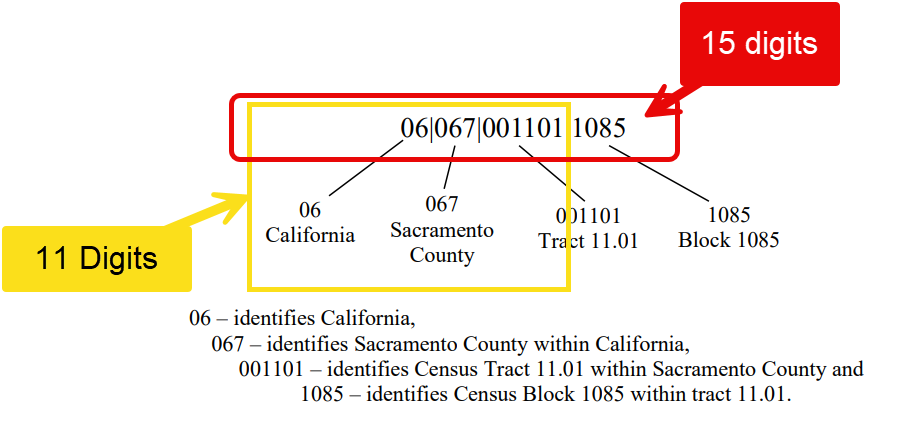
I do see a 'BLOCK' field in the output from Censusgeocode, in the top level key 2020 'Census Blocks':<p>
```
{'States': [{'STATENS': '01779798',
   'GEOID': '42',
  ...
   'INTPT': (-76.0273101, 41.1530284)}],
 '2020 Census Blocks': [{'SUFFIX': '',
   'GEOID': '420792166011027',
   'CENTLAT': '+40.9955117',
   'BLOCK': '1027',
   'AREAWATER': '0',
   'STATE': '42',
   'BASENAME': '1027',
   'OID': '210701003088971',
   'LSADC': 'BK',
   'FUNCSTAT': 'S',
   'INTPTLAT': '+40.9955117',
   'NAME': 'Block 1027',
   'OBJECTID': 5431639,
   'TRACT': '216601',
   'CENTLON': '-076.0096482',
   'BLKGRP': '1',
   'AREALAND': '1396400',
   'INTPTLON': '-076.0096482',
   'MTFCC': 'G5040',
   'LWBLKTYP': 'L',
   'UR': 'U',
   'COUNTY': '079',
   'CENT': (-76.0096482, 40.9955117),
   'INTPT': (-76.0096482, 40.9955117)}],
 'Census Tracts': [{'GEOID': '42079216601',
   'CENTLAT': '+41.0215278',
 ...
   'INTPT': (-75.4014459, 41.3543388)}]}
   ```

In [25]:
# Get 'BLOCK' field in the output from Censusgeocode, in the top level key 2020 'Census Blocks' for df_beat
# Adding 15 digit census_id to beat data set
def get_census_tract_block(lon, lat):
    """x=longitude  y=latitude"""
    result = cg.coordinates(x=lon, y=lat)
    return f"{result['Census Tracts'][0]['GEOID']}{result['2020 Census Blocks'][0]['BLOCK']}"

# Create a function that allows us to apply to a pandas row
def apply_census_tract_block(row):
    lon, lat = row['Longitude'], row['Latitude']
    # Use the function we just created to get the census tract from lon, lat
    census_tract = get_census_tract_block(lon, lat)
    return census_tract

df_beat['census_id'] = df_beat.apply(apply_census_tract_block, axis=1)
display(df_beat)

,Name,Location 1,Latitude,Longitude,tract,census_id
0,B1,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,53033001400,530330014004000
1,B2,"(47.6790521901374, -122.391748391741)",47.67905,-122.39175,53033003202,530330032021003
2,B3,"(47.6812920482227, -122.364236159741)",47.68129,-122.36424,53033002900,530330029003016
3,C1,"(47.6342500180223, -122.315684762418)",47.63425,-122.31568,53033006500,530330065001015
4,C2,"(47.6192385752996, -122.313557430551)",47.61924,-122.31356,53033007502,530330075022001
5,C3,"(47.6300792887474, -122.292087128251)",47.63008,-122.29209,53033006300,530330063002008
6,CITYWIDE,"(47.6210041048652, -122.332993498998)",47.62100,-122.33299,53033007303,530330073032000
7,D1,"(47.6274421308028, -122.345705781837)",47.62744,-122.34571,53033006702,530330067023005
8,D2,"(47.6256548876049, -122.331370005506)",47.62565,-122.33137,53033006600,530330066001024
9,D3,"(47.6103493249325, -122.328653706199)",47.61035,-122.32865,53033008300,530330083001003


#### (f) Extracting 11-digit codes from census 

Now, we will examine Census Dataset in the `census_data_2020_edu_attainment.csv` file. The data includes counts of education attainment across different census tracts. Note how this data is in a "wide" format and how it can be converted to a "long" format. For now, we will work with it as is. 

The census data contains a `GEO_ID` column. Among other things, this variable encodes the 11-digit code that we had extracted above for each of the police beats. Specifically, when we look at the characters after the characters "US" for values of GEO_ID, we see encodings for state, county, and tract, which should align with the beats we had above. Extract the 11-digit code from the `GEO_ID` column. Add a column named `census_id` to the Census Dataset with the 11-digit code for each census observation. Be sure to practice good data provenance when modifying a dataset.

In [26]:
df_education = pd.read_csv('census_data_2020_edu_attainment.csv')
print(df_education.columns.tolist())
display(df_education.head(3))
print(df_education.shape)

['GEO_ID', 'Population 18 to 24 years', 'Population 18 to 24 years-Less than high school graduate', 'Population 18 to 24 years-High school graduate (includes equivalency)', "Population 18 to 24 years-Some college or associate's degree", "Population 18 to 24 years-Bachelor's degree or higher", 'Population 25 years and over', 'Population 25 years and over-Less than 9th grade', 'Population 25 years and over-9th to 12th grade, no diploma', 'Population 25 years and over-High school graduate (includes equivalency)', 'Population 25 years and over-Some college, no degree', "Population 25 years and over-Associate's degree", "Population 25 years and over-Bachelor's degree", 'Population 25 years and over-Graduate or professional degree', 'Population 25 years and over-High school graduate or higher', "Population 25 years and over-Bachelor's degree or higher"]


,GEO_ID,Population 18 to 24 years,Population 18 to 24 years-Less than high school graduate,Population 18 to 24 years-High school graduate (includes equivalency),Population 18 to 24 years-Some college or associate's degree,Population 18 to 24 years-Bachelor's degree or higher,Population 25 years and over,Population 25 years and over-Less than 9th grade,"Population 25 years and over-9th to 12th grade, no diploma",Population 25 years and over-High school graduate (includes equivalency),"Population 25 years and over-Some college, no degree",Population 25 years and over-Associate's degree,Population 25 years and over-Bachelor's degree,Population 25 years and over-Graduate or professional degree,Population 25 years and over-High school graduate or higher,Population 25 years and over-Bachelor's degree or higher
0,1400000US53033000101,278,71,17,90,100,2718,187,80,492,362,250,949,398,2451,1347
1,1400000US53033000102,402,50,125,104,123,3578,75,172,717,379,315,981,939,3331,1920
2,1400000US53033000201,301,0,234,53,14,3616,15,232,412,512,199,1242,1004,3369,2246


(495, 16)


In [27]:
# Extract the Tract from GEO_ID in Education data
def extract_tract_from_geo_id(row):
    geo_id = row['GEO_ID'].upper()
    tract = ''
    if 'US' in geo_id:
        tract = geo_id.split('US')[1]
    if len(tract) == 11:
        return tract
# Apply the function to the DF
df_education['census_id'] = df_education.apply(extract_tract_from_geo_id, axis=1)
display(df_education)

,GEO_ID,Population 18 to 24 years,Population 18 to 24 years-Less than high school graduate,Population 18 to 24 years-High school graduate (includes equivalency),Population 18 to 24 years-Some college or associate's degree,Population 18 to 24 years-Bachelor's degree or higher,Population 25 years and over,Population 25 years and over-Less than 9th grade,"Population 25 years and over-9th to 12th grade, no diploma",Population 25 years and over-High school graduate (includes equivalency),"Population 25 years and over-Some college, no degree",Population 25 years and over-Associate's degree,Population 25 years and over-Bachelor's degree,Population 25 years and over-Graduate or professional degree,Population 25 years and over-High school graduate or higher,Population 25 years and over-Bachelor's degree or higher,census_id
0,1400000US53033000101,278,71,17,90,100,2718,187,80,492,362,250,949,398,2451,1347,53033000101
1,1400000US53033000102,402,50,125,104,123,3578,75,172,717,379,315,981,939,3331,1920,53033000102
2,1400000US53033000201,301,0,234,53,14,3616,15,232,412,512,199,1242,1004,3369,2246,53033000201
3,1400000US53033000202,228,0,54,102,72,3194,69,187,443,406,179,1174,736,2938,1910,53033000202
4,1400000US53033000300,477,25,60,318,74,1933,41,113,189,342,223,639,386,1779,1025,53033000300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1400000US53033032704,623,119,277,183,44,5243,215,167,629,1198,478,1593,963,4861,2556,53033032704
491,1400000US53033032705,109,80,15,14,0,2606,12,31,551,555,220,718,519,2563,1237,53033032705
492,1400000US53033032706,150,20,64,45,21,2134,3,46,501,517,348,640,79,2085,719,53033032706
493,1400000US53033032800,190,10,54,116,10,2085,14,66,363,470,216,640,316,2005,956,53033032800


### Problem 3: Census Data

#### (a) Join datasets part 1

Join the Census data in the with the (modified) Beat Dataset using the 11-digit codes as keys. Be sure that you do not lose any of the police beats when doing this join (i.e. your output dataframe should have the same number of rows as the cleaned Beats Dataset - use the correct join). Are there any police beats that do not have any associated census data? If so, how many? Save the resulting data in a different variable (i.e. don't overwrite the Beats or Census Datasets).

In [28]:
# I think I already did this in 1.0.3.3c, but will do it again here, making sure to do a full outer join
df_beat_new = df_beat.copy().drop(columns=['tract'])
df_beat_new.rename(columns={'Name': 'Beat'}, inplace=True)
df_beat_new['tract'] = df_beat_new.apply(apply_census_tract, axis=1)
display(df_beat_new)
print("There are no missing Beats because I made sure to confirm the lat lon data in the previous assignment")
# I frequently got time outs from their API endpoint

,Beat,Location 1,Latitude,Longitude,census_id,tract
0,B1,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
1,B2,"(47.6790521901374, -122.391748391741)",47.67905,-122.39175,530330032021003,53033003202
2,B3,"(47.6812920482227, -122.364236159741)",47.68129,-122.36424,530330029003016,53033002900
3,C1,"(47.6342500180223, -122.315684762418)",47.63425,-122.31568,530330065001015,53033006500
4,C2,"(47.6192385752996, -122.313557430551)",47.61924,-122.31356,530330075022001,53033007502
5,C3,"(47.6300792887474, -122.292087128251)",47.63008,-122.29209,530330063002008,53033006300
6,CITYWIDE,"(47.6210041048652, -122.332993498998)",47.62100,-122.33299,530330073032000,53033007303
7,D1,"(47.6274421308028, -122.345705781837)",47.62744,-122.34571,530330067023005,53033006702
8,D2,"(47.6256548876049, -122.331370005506)",47.62565,-122.33137,530330066001024,53033006600
9,D3,"(47.6103493249325, -122.328653706199)",47.61035,-122.32865,530330083001003,53033008300


There are no missing Beats because I made sure to confirm the lat lon data in the previous assignment


#### (b) Join datasets part 2

Then, join the Crime Dataset to our joined beat/census data. We can do this using the police beat name. Again, be sure you do not lose any observations from the (filtered) Crime Dataset. What are the final dimensions of the joined dataset? Save this joined dataset as you'll use it in a future problem set.

In [29]:
df_beat_new

,Beat,Location 1,Latitude,Longitude,census_id,tract
0,B1,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
1,B2,"(47.6790521901374, -122.391748391741)",47.67905,-122.39175,530330032021003,53033003202
2,B3,"(47.6812920482227, -122.364236159741)",47.68129,-122.36424,530330029003016,53033002900
3,C1,"(47.6342500180223, -122.315684762418)",47.63425,-122.31568,530330065001015,53033006500
4,C2,"(47.6192385752996, -122.313557430551)",47.61924,-122.31356,530330075022001,53033007502
5,C3,"(47.6300792887474, -122.292087128251)",47.63008,-122.29209,530330063002008,53033006300
6,CITYWIDE,"(47.6210041048652, -122.332993498998)",47.62100,-122.33299,530330073032000,53033007303
7,D1,"(47.6274421308028, -122.345705781837)",47.62744,-122.34571,530330067023005,53033006702
8,D2,"(47.6256548876049, -122.331370005506)",47.62565,-122.33137,530330066001024,53033006600
9,D3,"(47.6103493249325, -122.328653706199)",47.61035,-122.32865,530330083001003,53033008300


limit_output extension: Maximum message size of 10000 exceeded with 12830 characters

In [30]:
df_crime_new

,Report Number,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,occurred_dt,reported_dt,occurred_yr,reported_yr
0,1975000079415,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK,1975-12-16 09:00:00,1975-12-16 15:00:00,1975.0,1975
1,1976000069169,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,UNKNOWN,NaN,NaN,UNKNOWN,1976-01-01 00:01:00,1976-01-31 23:59:00,1976.0,1976
2,1979000049118,CAR PROWL,THEFT-CARPROWL,EAST,G,G2,CENTRAL AREA/SQUIRE PARK,1979-01-28 16:00:00,1979-02-09 14:30:00,1979.0,1979
3,19810000305573,HOMICIDE,HOMICIDE-PREMEDITATED-WEAPON,SOUTH,S,S2,BRIGHTON/DUNLAP,1981-08-22 20:29:00,1981-08-22 20:30:00,1981.0,1981
4,1981000076456,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTHWEST,W,W3,ROXHILL/WESTWOOD/ARBOR HEIGHTS,1981-02-14 20:00:00,1981-02-15 04:35:00,1981.0,1981
...,...,...,...,...,...,...,...,...,...,...,...
523586,2019000099944,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,SOUTH,O,O3,MID BEACON HILL,2019-03-20 17:13:00,2019-03-20 17:13:00,2019.0,2019
523587,2019000099946,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,EAST,C,C2,MONTLAKE/PORTAGE BAY,2019-03-20 07:30:00,2019-03-20 17:21:00,2019.0,2019
523588,2019000099949,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-BODYFORCE,SOUTH,S,S2,RAINIER BEACH,2019-03-20 17:24:00,2019-03-20 17:24:00,2019.0,2019
523589,2019000099974,THEFT-SHOPLIFT,THEFT-SHOPLIFT,NORTH,L,L2,NORTHGATE,2019-03-20 17:50:00,2019-03-20 19:04:00,2019.0,2019


In [31]:
# Making sure I am not missing any Beats between the two data sets
unique_beats = df_beat_new['Beat'].unique().tolist()
unique_beats_crime = [str(x) for x in df_crime_new['Beat'].unique() if pd.notna(x)]
print(sorted(unique_beats))
print(sorted(unique_beats_crime))

# Find beats in df_beat_new that are not in df_crime_new
missing_in_crime_new = sorted(set(unique_beats) - set(unique_beats_crime))

# Find beats in df_crime_new that are not in df_beat_new
missing_in_beat_new = sorted(set(unique_beats_crime) - set(unique_beats))

# Print the sorted unique values and the missing beats
print("Unique values in df_beat_new['Beat']:", sorted(unique_beats))
print("Unique values in df_crime_new['Beat']:", sorted(unique_beats_crime))
print("Beats in df_beat_new that are not in df_crime_new:", missing_in_crime_new)
print("Beats in df_crime_new that are not in df_beat_new:", missing_in_beat_new)

['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'CITYWIDE', 'D1', 'D2', 'D3', 'E', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'J1', 'J2', 'J3', 'K1', 'K2', 'K3', 'L1', 'L2', 'L3', 'M1', 'M2', 'M3', 'N', 'N1', 'N2', 'N3', 'O1', 'O2', 'O3', 'Q1', 'Q2', 'Q3', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3', 'SE', 'SW', 'U1', 'U2', 'U3', 'W', 'W1', 'W2', 'W3']
['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'CS', 'CTY', 'D1', 'D2', 'D3', 'DET', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'H1', 'INV', 'J1', 'J2', 'J3', 'K', 'K1', 'K2', 'K3', 'L1', 'L2', 'L3', 'LAPT', 'M1', 'M2', 'M3', 'N', 'N1', 'N2', 'N3', 'O1', 'O2', 'O3', 'Q1', 'Q2', 'Q3', 'R1', 'R2', 'R3', 'S', 'S1', 'S2', 'S3', 'SS', 'U1', 'U2', 'U3', 'W', 'W1', 'W2', 'W3', 'WS', 'X9']
Unique values in df_beat_new['Beat']: ['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'CITYWIDE', 'D1', 'D2', 'D3', 'E', 'E1', 'E2', 'E3', 'F1', 'F2', 'F3', 'G1', 'G2', 'G3', 'J1', 'J2', 'J3', 'K1', 'K2', 'K3', 'L1', 'L2', 'L3', 'M1', 'M2', 'M3', 'N', 'N1', 'N2', 'N3', 'O1', 'O2

In [33]:
# Perform a left join on the 'Beat' column
df_joined = pd.merge(df_crime_new, df_beat_new, on='Beat', how='outer')

# Print the final dimensions of the joined dataset
print(f'Final dimensions of the joined dataset: {df_joined.shape}')

# Display the first few rows of the joined dataset to verify
display(df_joined.head(100))

Final dimensions of the joined dataset: (523595, 16)


,Report Number,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood,occurred_dt,reported_dt,occurred_yr,reported_yr,Location 1,Latitude,Longitude,census_id,tract
0,2.007000e+13,ROBBERY-COMMERCIAL,ROBBERY-BUSINESS-GUN,NORTH,B,B1,BALLARD SOUTH,2007-09-13 22:28:00,2007-09-13 22:28:00,2007.0,2007.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
1,2.008000e+13,BURGLARY-COMMERCIAL,BURGLARY-NOFORCE-NONRES,NORTH,B,B1,BALLARD SOUTH,2008-03-17 18:30:00,2008-03-18 08:51:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
2,2.008000e+13,THEFT-BICYCLE,THEFT-BICYCLE,NORTH,B,B1,BALLARD SOUTH,2008-03-16 22:00:00,2008-03-19 01:13:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
3,2.008000e+13,THEFT-ALL OTHER,THEFT-OTH,NORTH,B,B1,BALLARD SOUTH,2008-03-17 17:00:00,2008-03-20 10:39:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
4,2.008000e+13,THEFT-ALL OTHER,THEFT-OTH,NORTH,B,B1,BALLARD SOUTH,2008-03-19 10:00:00,2008-03-20 11:28:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.008000e+13,THEFT-ALL OTHER,THEFT-OTH,NORTH,B,B1,BALLARD SOUTH,2008-04-26 00:00:00,2008-04-30 18:45:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
96,2.008000e+13,CAR PROWL,THEFT-CARPROWL,NORTH,B,B1,BALLARD SOUTH,2008-05-01 11:45:00,2008-05-02 15:40:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
97,2.008000e+13,THEFT-ALL OTHER,THEFT-OTH,NORTH,B,B1,BALLARD SOUTH,2008-05-02 13:30:00,2008-05-03 11:45:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
98,2.008000e+12,TRESPASS,TRESPASS,NORTH,B,B1,BALLARD SOUTH,2008-01-13 02:21:00,2008-01-13 02:21:00,2008.0,2008.0,"(47.7097756394592, -122.370990523069)",47.70978,-122.37099,530330014004000,53033001400
